<a href="https://colab.research.google.com/github/alqamahsayeed12/Air-Quality-Trainings/blob/Module-1/Module_1_Ground_Measurements_EPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MODULE-1 Ground Monitors by EPA

## Summary

This code visualizes ground monitor data obtained from the EPA. It aims to display the locations of ground monitors on a map and potentially represent levels of certain measurements, likely air quality.

**Key functionalities:**

* **Data Acquisition:** Uses the EPA API to access ground monitor data (requires an EPA API account).
* **Data Processing:** Extracts relevant information like longitude, latitude, and color values for visualization.
* **Visualization:** Creates a scatter plot using `matplotlib` to geographically represent the monitor data and potentially measurement levels.

## Pre requisite -
1. Make EPA - API account

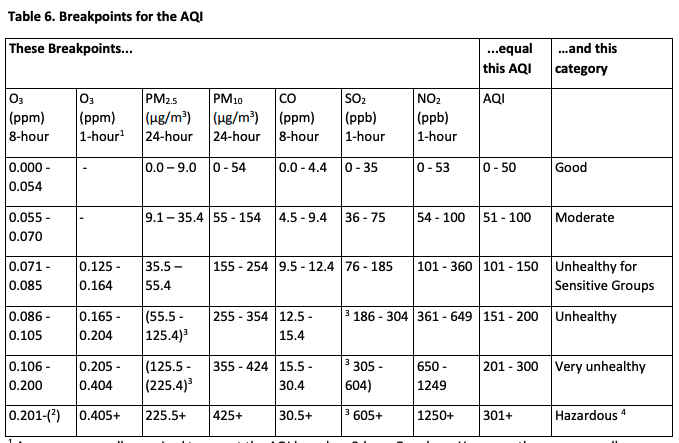

Link to make EPA account for Key: https://docs.airnowapi.org/

https://www.airnow.gov/aqi/aqi-basics-in-spanish/



In [ ]:
!pip install cartopy

In [ ]:
# imports
import pandas as pd
import os
import sys
from os.path import expanduser
import urllib
import urllib.request
import json
from datetime import date, datetime, timedelta
import matplotlib as mpl

import numpy as np
# import geopandas as gpd
import cartopy
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.shapereader as shpreader
import warnings
from geopy.geocoders import Nominatim
from math import e
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')

In [ ]:
# Import the 'drive' module from the 'google.colab' library.
# This module provides functions to interact with Google Drive within Colab.
from google.colab import drive

# Mount your Google Drive to the '/content/drive' path in the Colab environment.
# 'force_remount=True' ensures the Drive is remounted even if it was previously connected,
# preventing potential issues and refreshing the connection.
drive.mount('/content/drive', force_remount=True)

# Create a variable called 'NEED_PIP_INSTALL' and set it to True.
# This flag indicates whether certain Python packages need to be installed using 'pip'.
# It is typically set to True the first time the notebook is run to ensure all
# necessary dependencies are available.
NEED_PIP_INSTALL = True  # Set to True for initial package installation.

Mounted at /content/drive


**Basic Settings**
Decide whether to use pre-filled settings specified below in the code.

1.   If True, pre-filled settings are used.
2.   If False, null values are used, and users are asked to specify inputs in the following section.

Any values may be set to None, and the user will be asked to provide the requested input in the next section.

In [ ]:
# This variable controls whether to use pre-filled settings or prompt the user for input.
# Set to True to use pre-filled settings, False to prompt the user.
PRE_FILL_SETTINGS = True

# Check the value of PRE_FILL_SETTINGS and set variables accordingly.
if PRE_FILL_SETTINGS:
  # --- Pre-filled Settings ---

  # Define the geographical boundaries for the analysis.
  # Maximum Latitude:
  lat_max = 22.0
  # Maximum Longitude:
  lon_max = -74.0
  # Minimum Latitude:
  lat_min = 5.0
  # Minimum Longitude:
  lon_min = -107.0

  # Define the start and end dates and times for the analysis.
  # Using pd.to_datetime from the pandas library to create datetime objects.
  start = pd.to_datetime('2024-05-15 00:00:00')
  end = pd.to_datetime('2024-06-15 23:59:59')



  # Provide the API key for accessing the Air Quality System (AQS) data.
  AQS_key = "44C3A377-B4D6-4B19-AA37-4648F13757BF"

  # Options for data handling:
  # PREDOWNLOAD: Set to False, assuming data might not be pre-downloaded.
  PREDOWNLOAD = False
  # SAVEDATA: Set to True to save the downloaded data.
  SAVEDATA = True
  # GDRIVE: Set to True to load/save data from/to Google Drive.
  GDRIVE = True
  # data_path: Specify the path within Google Drive to store the data.
  data_path = '/content/drive/MyDrive/Guatemala_Training/EPA/'

  # Create the data directory if it doesn't exist.
  if not os.path.exists(data_path):
        os.makedirs(data_path)

else:
  # --- User Input Mode ---
  # If PRE_FILL_SETTINGS is False, set all variables to None.
  # This indicates that the user will be prompted to provide these values later.
  lat_max = None
  lon_max = None
  lat_min = None
  lon_min = None
  start = None
  end = None
  AQS_key = None
  CLOUD = None  # Not used in the provided code snippet
  PREDOWNLOAD = None
  SAVEDATA = None
  GDRIVE = None
  data_path = None

# Create a dictionary to store the data access options.
# This dictionary will be used later in the code to control data handling.
d_data_access_options = {
                         'PREDOWNLOAD': PREDOWNLOAD,
                         'SAVEDATA': SAVEDATA,
                         'GDRIVE': GDRIVE,
                         'data_path': data_path
                         }

In [ ]:
# --- User Input and Configuration ---

# This section gathers necessary information from the user to define the scope
# of the analysis and how the data should be handled.

## Definition of the analysis domain:
# Check if geographic boundaries and time period are already defined.
# If not, prompt the user for input.
if lat_max is None:
  lat_max = float(input('Please enter a maximum latitude to define the domain of interest:\n')) # Get max latitude from user
if lat_min is None:
  lat_min = float(input('Please enter a minimum latitude to define the domain of interest:\n')) # Get min latitude from user
if lon_max is None:
  lon_max = float(input('Please enter a maximum longitude to define the domain of interest:\n')) # Get max longitude from user
if lon_min is None:
  lon_min = float(input('Please enter a minimum longitude to define the domain of interest:\n')) # Get min longitude from user
if start is None:
  start = input('Please enter a start date and time (UTC) for the analysis.\nRequired format: YYYY-MM-DD hh:mm:s\n') # Get start date/time from user
  start = pd.to_datetime(start) # Convert start date/time to datetime object
if end is None:
  end = input('Please enter an end date and time (UTC) for the analysis.\nRequired format: YYYY-MM-DD hh:mm:s\n') # Get end date/time from user
  end = pd.to_datetime(end) # Convert end date/time to datetime object



## EPA AQS login information:
# Check if the AQS API key is already defined.
# If not, prompt the user for input.
if AQS_key is None:
  AQS_key = input('Please enter your EPA AQS API key:\n') # Get API key from user


## Data Access options:
# Define a function to get yes/no input from the user.
def f_y_n_prompt(s_prompt):
  b_output = None
  while b_output is None:
    s_q_a = input(s_prompt).strip() # Get user input and remove leading/trailing spaces
    if (s_q_a == 'Y') or (s_q_a == 'y') or (s_q_a == 'YES') or(s_q_a == 'Yes') or (s_q_a == 'yes'):
      b_output = True # Set output to True if user answers "yes"
    elif (s_q_a == 'N') or (s_q_a == 'n') or (s_q_a == 'NO') or(s_q_a == 'No') or (s_q_a == 'no'):
      b_output = False # Set output to False if user answers "no"
  return b_output # Return the boolean output

# If data is pre-downloaded, check if it's in Google Drive and get the path.
if PREDOWNLOAD is None:
  PREDOWNLOAD = f_y_n_prompt('Have you previously downloaded the datasets you wish to analyze? (Y/N)\n')

if PREDOWNLOAD:
  if GDRIVE is None:
    GDRIVE = f_y_n_prompt('Are the data to be analyzed saved in Google Drive? (Y/N)\n')
  if GDRIVE:
    drive.mount('/content/drive')
    if data_path is None:
      data_path = input('Please enter the path to the folder with the data in Google Drive:\nExample:"/content/drive/MyDrive/Data"\n')
  else:
    if data_path is None:
      data_path = input('Please enter the path to the folder with the data:\n')

# If data is not pre-downloaded, ask if the user wants to save it.
else:
  if SAVEDATA is None:
    SAVEDATA = f_y_n_prompt('Do you wish to save data for later analysis (Y/N)\nNote: If you choose "N", data will be temporarily downloaded and then deleted when it is no longer needed.\n')
  if SAVEDATA:
    if GDRIVE is None:
      GDRIVE = f_y_n_prompt('Do you wish to save the data to Google Drive? (Y/N)\n')
    if GDRIVE:
      drive.mount('/content/drive')
      if data_path is None:
        data_path = input('Please enter the path to the folder to save data to in Google Drive:\nExample:"/content/drive/MyDrive/Data"\n')
    else:
      if data_path is None:
        data_path = input('Please enter the path to the folder to save data to:\n')

# Save the data access options for future reference:
d_data_access_options = {
                         'PREDOWNLOAD':PREDOWNLOAD,
                         'SAVEDATA':SAVEDATA,
                         'GDRIVE':GDRIVE,
                         'data_path':data_path
                         }

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def download_airnow_df(variables='OZONE,PM25,PM10,CO,NO2,SO2',
                       t_start=start,
                       t_end=end,
                       lat_min=lat_min,
                       lat_max=lat_max,
                       lon_min=lon_min,
                       lon_max=lon_max,
                       key=AQS_key):
  """
  Downloads air quality data from the AirNow API.

  Args:
      variables (str, optional): Comma-separated list of pollutants to download.
                                  Defaults to 'OZONE,PM25,PM10,CO,NO2,SO2'.
      t_start (datetime, optional): Start date and time of the data request.
                                    Defaults to the `start` variable defined earlier.
      t_end (datetime, optional): End date and time of the data request.
                                  Defaults to the `end` variable defined earlier.
      lat_min (float, optional): Minimum latitude of the bounding box.
                                  Defaults to the `lat_min` variable defined earlier.
      lat_max (float, optional): Maximum latitude of the bounding box.
                                  Defaults to the `lat_max` variable defined earlier.
      lon_min (float, optional): Minimum longitude of the bounding box.
                                  Defaults to the `lon_min` variable defined earlier.
      lon_max (float, optional): Maximum longitude of the bounding box.
                                  Defaults to the `lon_max` variable defined earlier.
      key (str, optional): AirNow API key. Defaults to the `AQS_key` variable defined earlier.

  Returns:
      pandas.DataFrame: DataFrame containing the downloaded air quality data.
  """
  # Convert start and end times to the required format (YYYY-MM-DD)
  t_start = start.strftime('%Y-%m-%d')
  t_end = end.strftime('%Y-%m-%d')

  # Create a dictionary to store API request parameters
  options = {}
  options["url"] = "https://airnowapi.org/aq/data/" # Base URL for the AirNow API
  options["start_date"] = t_start  # Start date
  options["start_hour_utc"] = "00" # Start hour (UTC)
  options["end_date"] = t_end    # End date
  options["end_hour_utc"] = "23:59" # End hour (UTC)
  options["parameters"] = variables # Pollutants to download
  # Bounding box coordinates (longitude, latitude)
  options["bbox"] = f'{lon_min},{lat_min},{lon_max},{lat_max}'
  options["data_type"] = "c"       # Data type (c for current)
  options["format"] = "application/json" # Response format (JSON)
  options["verbose"] = "0"         # Verbosity level (0 for minimal output)
  options["api_key"] = key         # Your AirNow API key

  # Construct the API request URL
  REQUEST_URL = options["url"] \
          + "?startdate=" + options["start_date"] \
          + "t" + options["start_hour_utc"] \
          + "&enddate=" + options["end_date"] \
          + "t" + options["end_hour_utc"] \
          + "&parameters=" + options["parameters"] \
          + "&bbox=" + options["bbox"] \
          + "&datatype=" + options["data_type"] \
          + "&format=" + options["format"] \
          + "&api_key=" + options["api_key"]

  print(REQUEST_URL) # Print the API request URL

  # Send the API request and read the response
  with urllib.request.urlopen(REQUEST_URL) as response:
    json_page = response.read()       # Read the JSON response
    string_data = json_page.decode('utf-8') # Decode the JSON response to a string
    csv_data = pd.read_json(string_data)   # Convert the JSON string to a Pandas DataFrame

  return csv_data #

In [ ]:
def get_nearest_city_df(df, latitude_col='Latitude', longitude_col='Longitude'):
  """
  Fetches the nearest city and country for each row in a Pandas DataFrame.

  Args:
    df: The Pandas DataFrame containing latitude and longitude columns.
    latitude_col: The name of the latitude column (default: 'Latitude').
    longitude_col: The name of the longitude column (default: 'Longitude').

  Returns:
    The DataFrame with added columns 'Nearest_City' and 'Country'.
  """
  geolocator = Nominatim(user_agent="city_finder")

  def get_city_country(row):
    latitude = row[latitude_col]
    longitude = row[longitude_col]
    location = geolocator.reverse((latitude, longitude), exactly_one=True)

    if location:
      address = location.raw['address']
      city = address.get('city')
      town = address.get('town')
      village = address.get('village')
      country = address.get('country')

      nearest_city = city or town or village
      return nearest_city, country
    else:
      return None, None

  df[['Nearest_City', 'Country']] = df.apply(get_city_country, axis=1, result_type="expand")
  return df

In [ ]:
# Function to plot data on a map:
def plot_map(a_data_plot,
               n_lat_min=-90,
               n_lat_max=90,
               n_lon_min=-180,
               n_lon_max=180,
               my_cmap=plt.cm.get_cmap('jet'),
               Colorbar_Label=None,
               Plot_Title=None,
               Colorbar_Limits=None,
               Point_Size=None,
               Plot_Size=[12, 10]):
  """
  Creates and displays a map with data points plotted on it.

  Args:
    a_data_plot: Pandas DataFrame containing the data to plot.
                 Must have columns named 'Latitude', 'Longitude', and 'Value'.
    n_lat_min: Minimum latitude for the map extent. Defaults to -90.
    n_lat_max: Maximum latitude for the map extent. Defaults to 90.
    n_lon_min: Minimum longitude for the map extent. Defaults to -180.
    n_lon_max: Maximum longitude for the map extent. Defaults to 180.
    my_cmap: Colormap to use for the data points. Defaults to 'jet'.
    Colorbar_Label: Label for the colorbar. Defaults to None.
    Plot_Title: Title for the plot. Defaults to None.
    Colorbar_Limits: List containing the minimum and maximum values for the colorbar.
                     Defaults to None, which automatically determines the limits.
    Point_Size: Size of the data points on the map. Defaults to None.
    Plot_Size: List containing the width and height of the plot in inches.
               Defaults to [12, 10].

  Returns:
    matplotlib.figure.Figure: The figure object containing the map.
  """

  # Create the figure and axes for the plot:
  fig = plt.figure(figsize=Plot_Size)  # Create the figure with the specified size
  # Add a subplot with cartopy projection:
  mapobj = fig.add_subplot(1, 1, 1, projection=cartopy.crs.PlateCarree())

  # Add geographical features to the map:
  mapobj.coastlines()  # Draw coastlines
  # Add lakes with black edges, no fill, and slight transparency:
  mapobj.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='none', linestyle='-', alpha=0.3)
  # Set the map extent using provided latitude and longitude limits:
  mapobj.set_extent([np.max([n_lon_min, -180]) - 0.001,
                     np.min([n_lon_max, 180]) + 0.001,
                     np.max([n_lat_min, -90]) - 0.001,
                     np.min([n_lat_max, 90]) + 0.001])

  # Extract data for plotting:
  v_lat_plot = np.array(a_data_plot.Latitude)  # Latitude values
  v_lon_plot = np.array(a_data_plot.Longitude) # Longitude values
  v_data_temp = np.array(a_data_plot.Value)    # Data values

  # Plot the data points:
  if Colorbar_Limits is None:
    # Plot with automatic colorbar limits:
    plt.scatter(x=v_lon_plot, y=v_lat_plot, c=v_data_temp, cmap=my_cmap, s=Point_Size)
  else:
    # Plot with specified colorbar limits:
    plt.scatter(x=v_lon_plot, y=v_lat_plot, c=v_data_temp, vmin=Colorbar_Limits[0], vmax=Colorbar_Limits[1], cmap=my_cmap, s=Point_Size)

  # Add a colorbar and labels:
  if Colorbar_Label is not None:
    plt.colorbar().set_label(Colorbar_Label)  # Add colorbar with label
  else:
    plt.colorbar()  # Add colorbar without label

  if Plot_Title is not None:
    plt.title(Plot_Title)
  plt.show()
  return fig  # Return the figure object instead of the GeoAxes object

In [ ]:
# Function to plot data on a map:
def plot_map_aqi(a_data_plot,var=None,
               n_lat_min=-90,
               n_lat_max=90,
               n_lon_min=-180,
               n_lon_max=180,
               Colorbar_Label = None,
               Plot_Title = None,
               Colorbar_Limits = None,
               Point_Size = None,
               Plot_Size = [12,10],
               discrete_levels=None):  # Add discrete_levels parameter
  """
  Plots air quality data on a map using color-coded points to represent AQI categories.

  Args:
    a_data_plot: Pandas DataFrame containing the data to plot.
                 Must have columns named 'Latitude', 'Longitude', and 'Value'.
    var: Pollutant type ('PM25', 'PM10', or 'OZONE') to determine AQI bins.
    n_lat_min, n_lat_max, n_lon_min, n_lon_max: Geographical boundaries of the map.
    Colorbar_Label: Label for the colorbar.
    Plot_Title: Title for the plot.
    Colorbar_Limits: (Not used in this version) Could be used for custom colorbar limits.
    Point_Size: Size of the data points on the map.
    Plot_Size: Dimensions of the plot figure (width, height) in inches.
    discrete_levels: (Not used in this version) Could be used for discrete colorbar levels.
  """
  # Define AQI Bins and Labels based on Pollutant Type (var)
  if var == 'PM25':
    bins = [0, 9.0, 35.5, 55.5, 125.5, 225.5, 1000]  # PM2.5 AQI breakpoints
  elif var == 'PM10':
    bins = [0, 55, 155, 255, 355, 425, 1000]  # PM10 AQI breakpoints
  elif var == 'OZONE':
    bins = [0, 55, 70, 85, 105, 200, 1000] # Ozone AQI breakpoints
  elif var == 'CO':
    bins = [0, 4.5, 9.5, 12.5, 15.5, 30.5, 1000]  # CO AQI breakpoints
  elif var == 'NO2':
    bins = [0, 55, 115, 255, 355, 425, 1000]  # NO2 AQI breakpoints
  elif var == 'SO2':
    bins = [0, 35, 75, 185, 305, 604, 1000]  # SO2 AQI breakpoints
  else:
    raise ValueError("Invalid pollutant type. Choose 'PM25', 'PM10', or 'OZONE'.")


  # Define AQI category labels and colors
  labels2 = np.array(bins).astype('str')  # Convert bins to strings for colorbar ticks
  labels = ['Good', 'Moderate', 'Unhealthy for\nSensitive Groups',
            'Unhealthy', 'Very Unhealthy', 'Hazardous']  # AQI category names

  # Add 'AQI' column to the DataFrame using pd.cut to categorize values
  a_data_plot["AQI"] = pd.cut(a_data_plot['Value'], bins=bins, labels=labels)

  # Define colors for each AQI category
  colors = ['#00e400', '#ffff00', '#ff7e00', '#ff0000', '#8f3f97', '#7e0023']

  # Add 'colors' column to the DataFrame, assigning colors based on AQI category
  a_data_plot['colors'] = pd.cut(a_data_plot['Value'], bins=bins, labels=colors)

  # Create the map figure and axes
  mapobj = plt.figure(figsize=Plot_Size)  # Create the figure with specified size
  ax = mapobj.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())  # Add subplot with cartopy projection

  # Add geographical features
  ax.coastlines()  # Draw coastlines

  ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none',
                 linestyle='-', alpha=0.3)  # Add lakes

  # Set map extent (boundaries)
  ax.set_extent([np.max([n_lon_min, -180]) - 0.001,
                 np.min([n_lon_max, 180]) + 0.001,
                 np.max([n_lat_min, -90]) - 0.001,
                 np.min([n_lat_max, 90]) + 0.001])

  # Extract data for plotting
  v_lat_plot = np.array(a_data_plot.Latitude)  # Latitude values
  v_lon_plot = np.array(a_data_plot.Longitude) # Longitude values
  v_data_temp = np.array(a_data_plot.Value)    # Pollutant concentration values (not directly used for plotting in this version)

  # Create scatter plot with discrete colorbar
  scatter = ax.scatter(x=v_lon_plot, y=v_lat_plot, c=a_data_plot.colors, s=Point_Size,edgecolors='black', linewidths=1)
  # Plots data points using longitude (x), latitude (y), colors from 'colors' column, and specified point size

  # Create custom colorbar with AQI categories
  bounds = bins  # AQI category boundaries (defined earlier)
  cmap = mpl.colors.ListedColormap(colors)  # Create colormap from the 'colors' list
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N) # Normalize colormap to AQI boundaries

  # Add the colorbar to the plot
  cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
                          ax=ax, orientation='vertical', ticks=bins)
  # Creates and adds the colorbar, using the defined colormap and normalization
  #cbar = plt.colorbar(scatter, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)  # Alternative way to add colorbar (commented out)
  #cbar.ax.set_yticklabels(['Good', 'Moderate',  # ... (rest of labels) ... ])  # Set custom tick labels (commented out)
  cbar.ax.set_yticklabels(labels2)  # Set tick labels using the bin values as strings
  cbar.set_label(Colorbar_Label)   # Set the colorbar label if provided

  if Plot_Title is not None:
    plt.title(Plot_Title)
  plt.show()
  return mapobj

In [ ]:
# Get the pollutant the user wants to analyze
var = input('Please enter pollutant you want to process (Eg. -> PM25 , PM10, NO2, CO, OZONE or SO2)\n')

# Keep asking until a valid pollutant is entered
while var not in ['PM25','PM10','NO2','CO','OZONE','SO2']:
  var = input('Please enter pollutant you want to process (Eg. -> PM25 , PM10, NO2, CO, OZONE or SO2)\n')

if var == 'OZONE':
  #Download only 10 days from start date
  end = start + pd.Timedelta(days=10)

#Download if file doesnot exists:
if not os.path.exists(data_path+f'{var}_{start.strftime("%Y%m%d")}_{end.strftime("%Y%m%d")}.csv'):
  print(f'Downloading {var} data')
  # Download data for the selected pollutant using the download_airnow_df function
  df = download_airnow_df(variables=var)

  # Extract the unit of measurement for the pollutant
  unit = df['Unit'].iloc[0]

  # Save the downloaded data to a CSV file with a descriptive filename
  df.to_csv(data_path+f'{var}_{start.strftime("%Y%m%d")}_{end.strftime("%Y%m%d")}.csv')
else:
  # If the data file already exists, load it from the CSV file
  df = pd.read_csv(data_path+f'{var}_{start.strftime("%Y%m%d")}_{end.strftime("%Y%m%d")}.csv')

# Convert the 'UTC' column to datetime objects for proper time handling
df['UTC'] = pd.to_datetime(df['UTC'])

# Replace negative values in the 'Value' column with NaN (missing data)
df[df.Value < 0] = np.nan

# Remove rows with missing values (NaN) to clean the data
df = df.dropna()

# Calculate the average pollutant value for each unique latitude and longitude
df_avg = df[['Latitude','Longitude','Value',]].groupby(['Latitude','Longitude']).mean().reset_index()

# Calculate the daily average pollutant value for each unique latitude and longitude
daily_mean = df.groupby([df['UTC'].dt.date, 'Latitude', 'Longitude'])['Value'].mean().reset_index()

https://airnowapi.org/aq/data/?startdate=2024-05-15t00&enddate=2024-06-15t23:59&parameters=PM25&bbox=-107.0,5.0,-74.0,22.0&datatype=c&format=application/json&api_key=44C3A377-B4D6-4B19-AA37-4648F13757BF


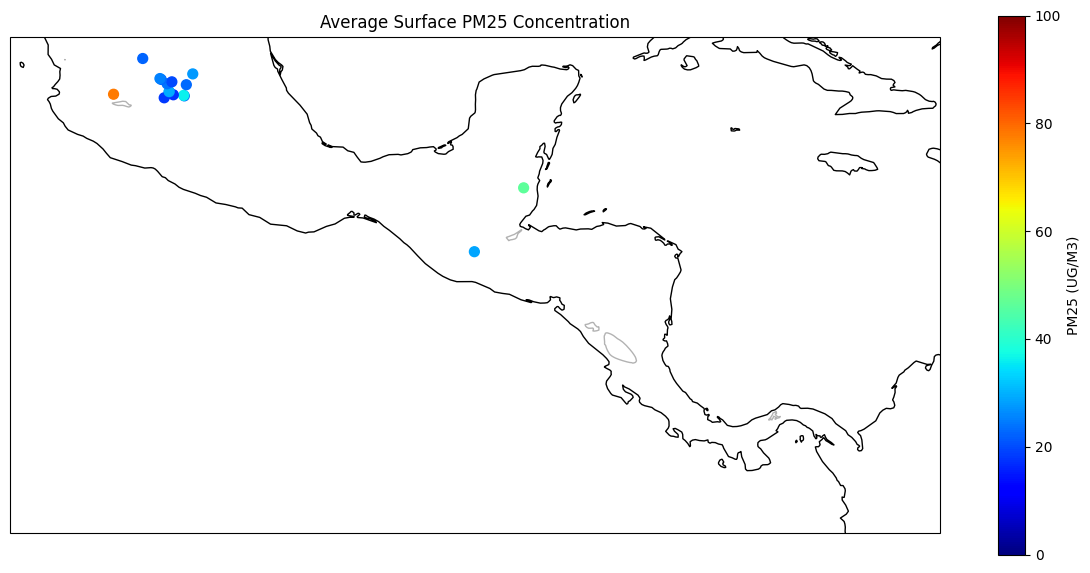

In [ ]:
# Calculate the maximum value for the colorbar, rounded up to the nearest 50
# This ensures the colorbar has a nice range and is visually appealing
max1 = ((df_avg.Value).max() // 50 + 1) * 50

# Call the `plot_map` function to create the map visualization
# The `plot_map` function is defined earlier in the code and takes several arguments:
#   - `df_avg`: The DataFrame containing the data to plot (average pollutant values)
#   - `n_lat_min`, `n_lat_max`, `n_lon_min`, `n_lon_max`: Geographic boundaries for the map
#   - `my_cmap`: The colormap to use for the data points ('jet' in this case)
#   - `Colorbar_Label`: Label for the colorbar (includes pollutant name and unit)
#   - `Plot_Title`: Title of the map plot
#   - `Colorbar_Limits`: Range of values for the colorbar (0 to `max1`)
#   - `Point_Size`: Size of the data points on the map
#   - `Plot_Size`: Dimensions of the map plot (width, height)
EPA = plot_map(df_avg,
               n_lat_min=lat_min,
               n_lat_max=lat_max,
               n_lon_min=lon_min,
               n_lon_max=lon_max,
               my_cmap=plt.cm.get_cmap('jet'),
               Colorbar_Label=f'{var} ({unit})',
               Plot_Title=f'Average Surface {var} Concentration',
               Colorbar_Limits=[0, max1],
               Point_Size=50,
               Plot_Size=[15, 7]
               )

# Save the generated map plot to a PNG file
# The filename includes the pollutant name, start date, and end date
# `data_path` is a variable defined earlier to specify the directory for saving files
EPA.savefig(data_path + f'Avg_{var}_{start.strftime("%Y%m%d")}_{end.strftime("%Y%m%d")}.png')

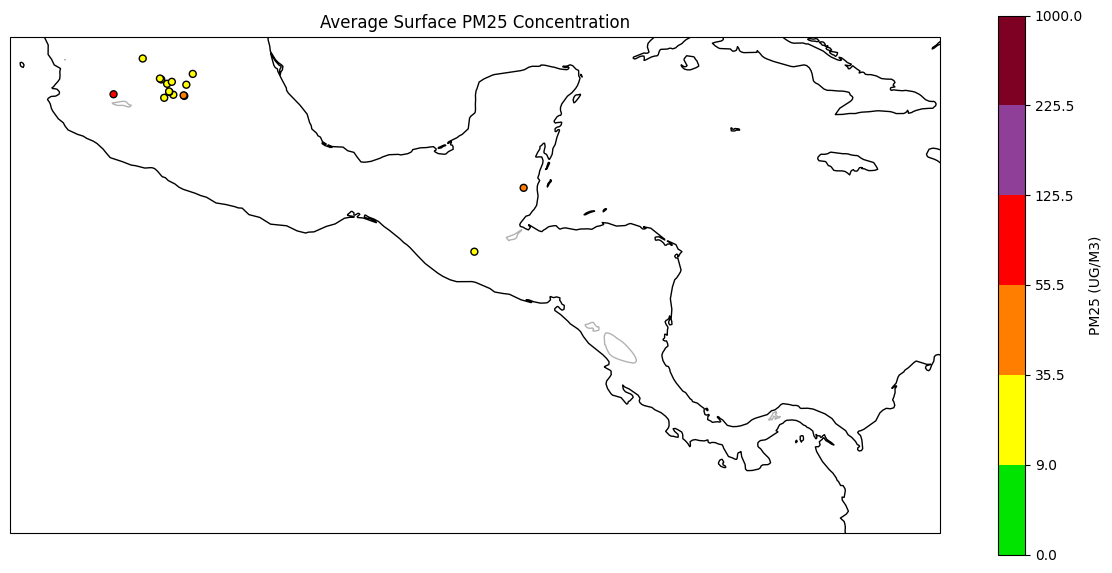

In [ ]:
# Plot Avg at all locations the data:
# This line is a comment, providing context for the code that follows.
# It indicates that the code below will plot the average pollutant values on a map.

EPA_AQI = plot_map_aqi(
    df_avg,  # The DataFrame containing the average pollutant values to be plotted.
    var,  # The pollutant type (e.g., 'PM25', 'PM10', 'OZONE').
    n_lat_min=lat_min,  # Minimum latitude for the map extent.
    n_lat_max=lat_max,  # Maximum latitude for the map extent.
    n_lon_min=lon_min,  # Minimum longitude for the map extent.
    n_lon_max=lon_max,  # Maximum longitude for the map extent.
    Colorbar_Label=f'{var} ({unit})',  # Label for the colorbar, showing pollutant and unit.
    Plot_Title=f'Average Surface {var} Concentration',  # Title of the plot.
    Colorbar_Limits=[0, 1000],  # Range of values for the colorbar.
    Point_Size=25,  # Size of the data points on the map.
    Plot_Size=[15, 7],  # Dimensions of the plot (width, height).
    discrete_levels=7  # Number of discrete levels for the colorbar (not used in this version).
)

# This line calls the `plot_map_aqi` function to create the map visualization.
# The function takes the data and various parameters to customize the map's appearance.
# The result of the function call (the map figure) is stored in the `EPA_AQI` variable.

EPA_AQI.savefig(
    data_path + f'Avg_{var}_AQI_{start.strftime("%Y%m%d")}_{end.strftime("%Y%m%d")}.png'
)
# This line saves the generated map plot to a PNG file.


In [ ]:
# Plot Last n days Avg at all locations the data:
max_value = (daily_mean.Value.max() // 10 + 1) * 10  # Calculate the maximum value for the colorbar, rounded up to the nearest 10
print(f'Max: {max_value}, Min: {min}')  # Print the maximum and minimum values (min is assumed to be defined elsewhere in your code)

# Get the number of days the user wants to look back
n = input("How many days do you want to look back?\n")

# Keep asking until the user enters a valid number
while not n.isdigit():
  n = input("How many days do you want to look back?\n")

# Convert the input string to an integer
n = int(n)

# Get the unique dates in the 'UTC' column and select the last 'n' days
days = daily_mean.UTC.unique()[-n:]

# Filter the daily_mean DataFrame to include only data from the selected days
daily_mean = daily_mean[daily_mean.UTC.isin(days)]

# Iterate through each selected day
for day in days:
  # Extract data for the current day
  df_day = daily_mean[daily_mean.UTC == day]

  # Call the plot_map function to create and display the map for the current day
  EPA = plot_map(df_day,  # DataFrame for the current day
                    n_lat_min=lat_min,  # Minimum latitude
                    n_lat_max=lat_max,  # Maximum latitude
                    n_lon_min=lon_min,  # Minimum longitude
                    n_lon_max=lon_max,  # Maximum longitude
                    Colorbar_Label=f'{var} ({unit})',  # Colorbar label
                    Plot_Title=f'Daily Average Surface {var} Concentration - {day}',  # Plot title
                    Colorbar_Limits=[0, max_value],  # Colorbar limits
                    Point_Size=100,  # Size of data points
                    Plot_Size=[15, 7]  # Plot dimensions
                )

In [ ]:
# Plot Last n days Avg at all locations with AQI:
# ... (other code remains the same, including max_value calculation and n input) ...

# Get the unique dates in the 'UTC' column and select the last 'n' days
days = daily_mean.UTC.unique()[-n:]

# Filter the daily_mean DataFrame to include only data from the selected days
daily_mean = daily_mean[daily_mean.UTC.isin(days)]

# Iterate through each selected day
for day in days:
  # Extract data for the current day
  df_day = daily_mean[daily_mean.UTC == day]

  # Call the plot_map_aqi function to create and display the map with AQI for the current day
  EPA_AQI = plot_map_aqi(df_day,  # DataFrame for the current day
                        var,  # Pollutant type (e.g., 'PM25', 'PM10', 'OZONE')
                        n_lat_min=lat_min,  # Minimum latitude
                        n_lat_max=lat_max,  # Maximum latitude
                        n_lon_min=lon_min,  # Minimum longitude
                        n_lon_max=lon_max,  # Maximum longitude
                        Colorbar_Label=f'{var} ({unit})',  # Colorbar label
                        Plot_Title=f'Daily Average Surface {var} Concentration - {day}',  # Plot title
                        Point_Size=100,  # Size of data points
                        Plot_Size=[15, 7]  # Plot dimensions
                      )

  # You can save the figure if needed, similar to before:
  # EPA_AQI.savefig(data_path + f'Avg_{var}_AQI_{day.strftime("%Y%m%d")}.png')

In [ ]:
import seaborn as sns  # Import Seaborn for styling

# --- Code snippet for plotting individual location time series ---
# Ask user for daily or hourly data preference
daily = input('Input "D" for Daily or "H" for Hourly\n')
while daily not in ['D', 'H', 'd', "h"]:
    daily = input('Input "D" for Daily or "H" for Hourly\n')


# Loop through each unique location
for i in range(len(locations)):
    # Get latitude and longitude of the current location
    lat = locations.loc[i, 'Latitude']
    lon = locations.loc[i, 'Longitude']

    # Filter data for the current location
    df_temp = df[(df.Latitude == lat) & (df.Longitude == lon)]

    # Get nearest city information (using a function defined elsewhere)
    df2 = get_nearest_city_df(df_temp[['Latitude', "Longitude"]].drop_duplicates())

    # Set 'UTC' column as index and select only 'Value' column
    df_temp.index = df_temp.UTC
    df_temp = df_temp[['Value']]

    # Resample data to daily or hourly averages based on user input
    if daily.upper() == 'D':  # Using upper() for case-insensitivity
        df_temp = df_temp.resample('D').mean()
    else:
        df_temp = df_temp.resample('H').mean()

    # --- Plotting ---

    # Apply Seaborn style for a more polished look
    sns.set_style("whitegrid")  # Use a whitegrid background
    sns.set_context("talk")  # Set context for larger font sizes



    # Create figure and axes
    fig, ax = plt.subplots(figsize=(12, 8))  # Increased figure size

    # Plot the data as a line with markers
    ax.plot(df_temp.index, df_temp['Value'], marker='o', linestyle='-',
            color='#007acc', linewidth=2, markersize=6,
            label=f'{var} Concentration')  # Added a label and custom color

    # Set plot title, including city and country information
    ax.set_title(f'Surface {var} Concentration in {df2.Nearest_City.iloc[0]}, {df2.Country.iloc[0]}',
                 fontsize=16, fontweight='bold')  # Increased title size and weight

    # Set x and y axis labels with improved formatting
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel(f'{var} ({unit})', fontsize=14)

    # Format x-axis ticks for date display with better spacing
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))  # Limit number of ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate()  # Rotate x-axis labels

    # Add gridlines with customization
    ax.grid(True, linestyle='--', alpha=0.5, color='gray')  # Lighter gridlines

    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add a legend for better clarity
    ax.legend(fontsize=12, loc='upper right')

    # Add a subtle background shading
    ax.fill_between(df_temp.index, df_temp['Value'], color='#007acc', alpha=0.1)

    # Add annotations for minimum and maximum values
    min_val = df_temp['Value'].min()
    max_val = df_temp['Value'].max()
    min_idx = df_temp['Value'].idxmin()
    max_idx = df_temp['Value'].idxmax()


    # Display the plot
    plt.tight_layout()
    plt.show()